# Import

In [1]:
# #.py modules
# import acquire as ac
# import prepare as p
import explore as e
# import evaluate as ev
import wrangle as w

#standard
import pandas as pd
import numpy as np
import re

#scraping
import requests
from requests import get
from bs4 import BeautifulSoup

#file
import os
import json
from google.oauth2 import service_account
import pandas_gbq

#vizz
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#split and model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#set random state
random_state=123

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

imports loaded successfully, awaiting commands...


In [2]:
# pd.set_option('display.max_colwidth', None)

In [3]:
df = w.check_file_exists_gbq('cfpb.csv', 'service_key.json')

csv file found and loaded


In [4]:
# df_clean = w.clean_data(df)

In [5]:
# df_clean.to_parquet('df_clean.parquet')

In [6]:
df_clean = pd.read_parquet('df_clean.parquet')

In [7]:
df_clean.head()

,date_received,narrative,company_name,state,tags,company_response_to_consumer,product_bins
0,2019-03-02,"I was locked out of my credit report by XXXX, ...",Experian Information Solutions Inc.,IL,Average Person,Closed with explanation,credit_report
1,2022-12-11,I asked that the credit agency remove negative...,Experian Information Solutions Inc.,MS,Average Person,Closed with non-monetary relief,credit_report
2,2017-07-26,Dear XXXX XXXX XXXX ( Citibank/The Student Loa...,"CITIBANK, N.A.",CT,Average Person,Closed with explanation,debt_collection
3,2017-12-14,Dear CFPB Attached below is a copy of my corre...,"Coinbase, Inc.",UNKNOWN,Average Person,Closed with explanation,money_service
4,2021-07-08,I have submitted multiple requests by mail to ...,Experian Information Solutions Inc.,KY,Average Person,Closed with non-monetary relief,credit_report


In [8]:
# df_prep = w.prep_narrative(df_clean)

In [9]:
# df_prep.to_parquet('df_prep.parquet')

In [10]:
df_prep = pd.read_parquet('df_prep.parquet')

In [11]:
# train, validate, test = w.split_data(df_prep,"company_response_to_consumer")

# Prepared DF: (1246736, 10)
# Train: (748041, 10)
# Validate: (249347, 10)
# Test: (249348, 10)

In [12]:
# train.to_parquet('train.parquet')
# validate.to_parquet('validate.parquet')
# test.to_parquet('test.parquet')

In [13]:
train = pd.read_parquet('train.parquet')
validate = pd.read_parquet('validate.parquet')
test = pd.read_parquet('test.parquet')

In [14]:
# Print the summary statistics of the DataFrame
train.describe()

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
count,748041,748041,748041,748041,748041,748041,748041,748041
unique,2907,4925,64,4,5,7,623996,589259
top,2023-01-20 00:00:00,"EQUIFAX, INC.",CA,Average Person,Closed with explanation,credit_report,in accordance with the fair credit reporting a...,accordance fair credit act account u c section...
freq,1272,117214,92628,640169,589373,384123,2340,3792
first,2015-03-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-03-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Count the number of non-NA values
print(train.count())

date_received                   748041
company_name                    748041
state                           748041
tags                            748041
company_response_to_consumer    748041
product_bins                    748041
clean                           748041
lemon                           748041
dtype: int64


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748041 entries, 943705 to 842779
Data columns (total 8 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date_received                 748041 non-null  datetime64[ns]
 1   company_name                  748041 non-null  object        
 2   state                         748041 non-null  object        
 3   tags                          748041 non-null  object        
 4   company_response_to_consumer  748041 non-null  object        
 5   product_bins                  748041 non-null  object        
 6   clean                         748041 non-null  object        
 7   lemon                         748041 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 51.4+ MB


## Do specific words tend to receive specific responses? For example, do words related to fraud tend to receive more "closed with relief" responses compared to other issues?

## "Is there a relationship between consumer complaint words and company response?"

Initial Thoughts:
* Separation each word by row and then will be doing a count of how many times the word appears in the lemon column.
* Use a small sample in this case we will only use a max_features of 20,000
* Count Words: Use a tool like CountVectorizer in Python to count how often each word appears in the complaints.
* Compare: Calculate the average count of each word for each type of company response to see which words are used most often.
* Visualize: Create a barplot visual to show which words are most associated with each type of company response.
* Use your word counts to predict the company response using machine learning techniques.

In [17]:
word_counts, df_with_words,word_counts_ones = e.get_word_counts(train)

In [27]:
word_counts

,aa,aam,aba,aback,abandon,abandoned,abandonment,abate,abatement,abb,...,zinc,zip,zipper,zombi,zombie,zone,zoned,zoning,zoo,zoom
company_response_to_consumer,,,,,,,,,,,,,,,,,,,,,
Closed,0,0,0,1,0,1,1,0,0,0,...,0,1,0,0,3,3,0,0,0,0
Closed with explanation,173,1,39,41,56,319,48,6,66,0,...,3,516,7,1,70,320,8,16,5,15
Closed with monetary relief,4,0,0,0,2,15,3,0,2,0,...,0,24,0,0,6,16,0,0,1,1
Closed with non-monetary relief,55,0,3,8,10,76,11,5,29,0,...,0,171,0,0,16,85,4,3,1,2
Untimely response,0,0,0,0,0,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [28]:
df_with_words

,aa,aam,aba,aback,abandon,abandoned,abandonment,abate,abatement,abb,...,zip,zipper,zombi,zombie,zone,zoned,zoning,zoo,zoom,company_response_to_consumer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with explanation
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with non-monetary relief
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with non-monetary relief
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with explanation
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with non-monetary relief
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with explanation
748034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with explanation
748037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with monetary relief
748038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Closed with explanation


In [29]:
word_counts_ones

,aa,aam,aba,aback,abandon,abandoned,abandonment,abate,abatement,abbreviate,...,zinc,zip,zipper,zombi,zombie,zone,zoned,zoning,zoo,zoom
company_response_to_consumer,,,,,,,,,,,,,,,,,,,,,
Closed,0,0,0,1,0,1,1,0,0,0,...,0,1,0,0,3,3,0,0,0,0
Closed with explanation,173,1,39,41,56,319,48,6,66,4,...,3,516,7,1,70,320,8,16,5,15
Closed with monetary relief,4,0,0,0,2,15,3,0,2,0,...,0,24,0,0,6,16,0,0,1,1
Closed with non-monetary relief,55,0,3,8,10,76,11,5,29,2,...,0,171,0,0,16,85,4,3,1,2
Untimely response,0,0,0,0,0,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [30]:
word_counts_ones.columns

Index(['aa', 'aam', 'aba', 'aback', 'abandon', 'abandoned', 'abandonment',
       'abate', 'abatement', 'abbreviate',
       ...
       'zinc', 'zip', 'zipper', 'zombi', 'zombie', 'zone', 'zoned', 'zoning',
       'zoo', 'zoom'],
      dtype='object', length=19269)

In [18]:
top = e.top_15_words(word_counts_ones)

In [19]:
top.T

,Closed with explanation,Closed,Closed with monetary relief,Closed with non-monetary relief,Untimely response
credit,601325.0,2129.0,27822.0,160875.0,2468.0
account,491614.0,1607.0,22698.0,132269.0,1997.0
report,301766.0,1092.0,13704.0,79752.0,1121.0
information,290256.0,1144.0,13548.0,76183.0,1184.0
consumer,177051.0,657.0,7943.0,45478.0,703.0
payment,173992.0,560.0,7794.0,47668.0,665.0
time,171721.0,627.0,7879.0,45798.0,658.0
would,166387.0,592.0,7639.0,44675.0,685.0
debt,158404.0,619.0,7508.0,42458.0,677.0
day,154556.0,549.0,6991.0,40892.0,625.0


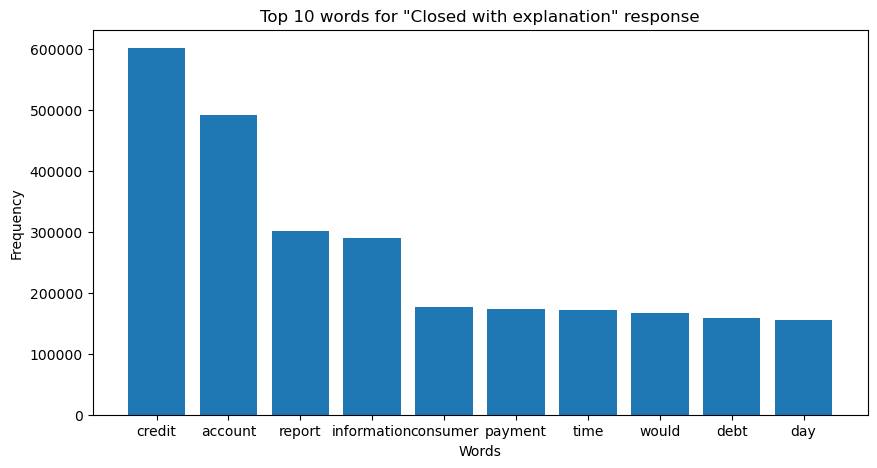

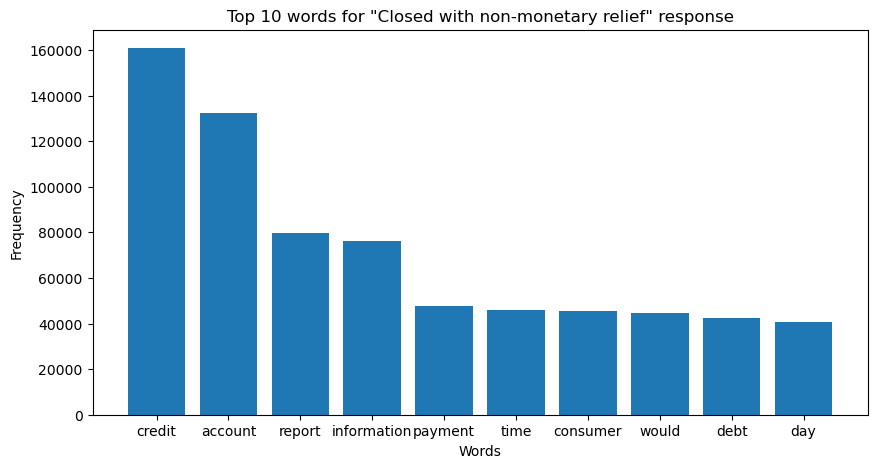

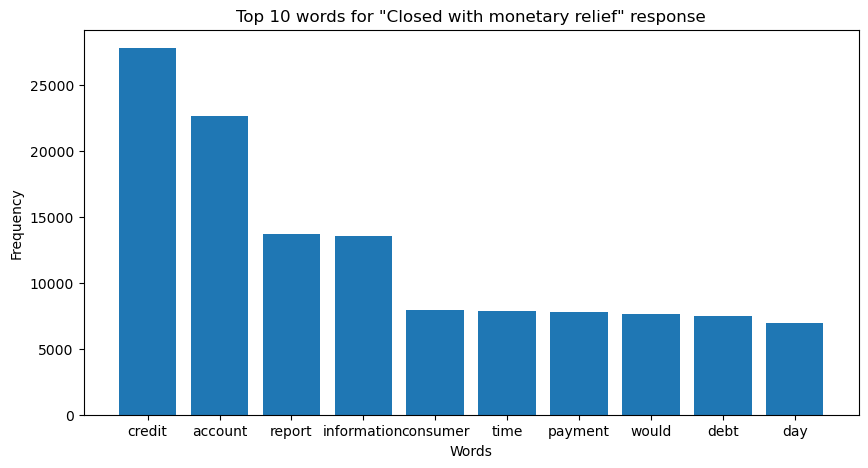

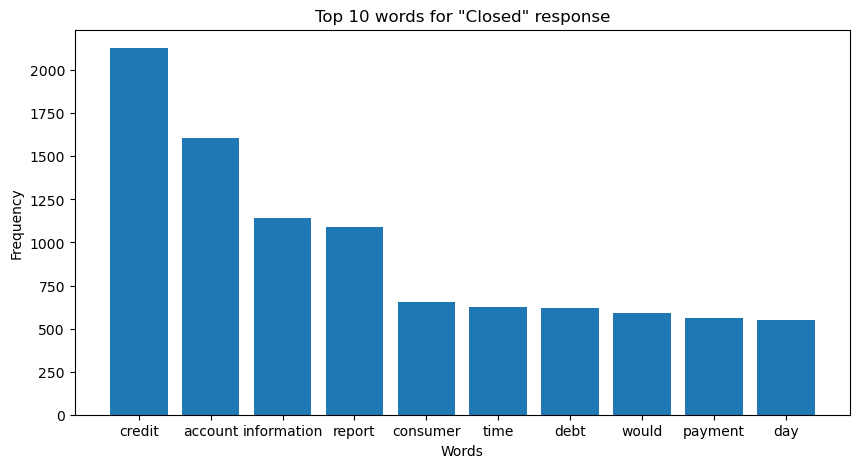

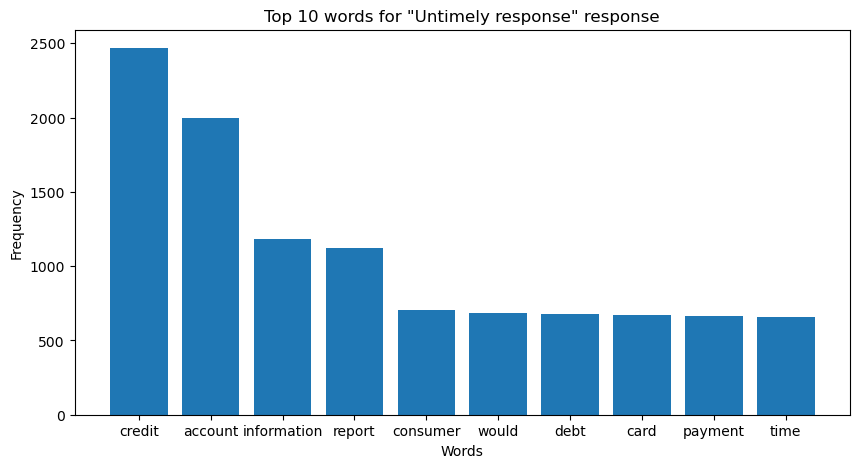

In [20]:
e.frequenct_words_plot(df_with_words,word_counts_ones)

In [21]:
# Get the unique response types
response_types = df_with_words['company_response_to_consumer'].unique()

# Initialize an empty dictionary to store the unique words for each response type
unique_words = {}

# For each response type
for response in response_types:
    # Get the words associated with this response type
    words = word_counts_ones.loc[response]
    
    # Get the words that are unique to this response type
    unique = words[~words.index.isin(np.concatenate([word_counts_ones.loc[other].index for other in response_types if other != response]))]
    
    # Add the unique words to the dictionary
    unique_words[response] = unique.index.tolist()

# Print the unique words for each response type
for response, words in unique_words.items():
    print(f'Unique words for "{response}" response:')
    print(words)
    print('\n')


Unique words for "Closed with explanation" response:
[]


Unique words for "Closed with non-monetary relief" response:
[]


Unique words for "Closed with monetary relief" response:
[]


Unique words for "Closed" response:
[]


Unique words for "Untimely response" response:
[]




# TAKEWAY
* Based on the top 15 words there are no specific words that are associated with a specific respond.   

* Common Words: 
    The most common words in all company responses are: 
    "account",
    "credit",
    "report",
    "information",
    "payment",
    "loan",
    "time",
    "would",
    "debt",
    "company",
    and "day"     
* No Specific Words: 
    There are no specific words that are only associated with a certain type of company response. This means companies use similar language regardless of their response type. 
    
* "Account" is Popular: 
    The word "account" is the most frequently used word in company responses. This suggests that many complaints are related to issues with accounts.  
    
* Response Types: 
    The response type "Closed with explanation" has the highest word count for all the top words. This means that companies tend to use more words when they are providing an explanation. 
    
* Less Words for "Untimely response": 
    Companies use fewer words in their responses when the response is "Untimely response". This could mean that when companies respond late, they tend to provide less detailed responses.    

In [22]:
# Initialize an empty dictionary to store the unique words for each response type
unique_words = {}

# For each response type
for response in response_types:
    # Get the words associated with this response type
    words = word_counts_ones.loc[response]
    
    # Calculate the difference in frequency between this response type and the others
    diff = words - word_counts_ones.loc[[other for other in response_types if other != response]].mean()
    
    # Convert the sparse Series to a dense one
    diff_dense = diff.sparse.to_dense()
    
    # Get the top 10 words with the highest difference in frequency
    unique = diff_dense.nlargest(10)
    
    # Add the unique words to the dictionary
    unique_words[response] = unique.index.tolist()

# Print the unique words for each response type
for response, words in unique_words.items():
    print(f'Unique words for "{response}" response:')
    print(words)
    print('\n')


Unique words for "Closed with explanation" response:
['credit', 'account', 'report', 'information', 'consumer', 'payment', 'time', 'would', 'debt', 'day']


Unique words for "Closed with non-monetary relief" response:
['account', 'credit', 'payment', 'loan', 'card', 'pay', 'would', 'balance', 'received', 'one']


Unique words for "Closed with monetary relief" response:
['differ', 'zed', 'pierce', 'linear', 'polestar', 'ascending', 'bedding', 'chancery', 'thermostat', 'indenture']


Unique words for "Closed" response:
['carhop', 'horse', 'hop', 'keyless', 'destitution', 'beknown', 'pornographic', 'resolver', 'sexually', 'shatter']


Unique words for "Untimely response" response:
['elevon', 'pottery', 'exacting', 'escalator', 'carnival', 'cube', 'transmitter', 'contiguous', 'forcefulness', 'friar']




In [23]:
import pandas as pd

def create_dataframe():
    """
    This function creates a DataFrame that contains information about the columns of a dataset.
    The DataFrame includes the column name, the percentage of null values in the column, the number of unique values in the column, and the decision made about how to handle the column for further analysis.

    Returns:
        df (DataFrame): A pandas DataFrame that contains the column information.
    """

    # Create a dictionary with your data
    data = {
        "Column Name": ["product", "subproduct", "issue", "subissue", "consumer_complaint_narrative", "company_public_response", "zip code", "consumer_consent_provided", "submitted_via", "date_sent_to_company", "timely_response", "consumer_disputed", "complaint_id"],
        "Null Values": ["0%", "7%", "0%", "20%", "64%", "56%", "1%", "25%", "0%", "0%", "0%", "77%", "0%"],
        "Unique Values": ["-", "-", "165", "221", "-", "-", "-", "-", "-", "-", "-", "-", "-"],
        "Decision": ["Engineered Feature: Bin related products/services together then drop", "Drop", "Future Iteration", "Drop", "Renamed to narrative, drop all null values, drop after NLTK cleaning", "Keep for analysis", "Future Iteration", "Drop", "Drop", "Future Iteration", "Future Iteration", "Future Iteration", "Drop"]
    }

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)

    # Reset the index and drop the index column
    df.reset_index(drop=True, inplace=True)

    return df



In [24]:
df = create_dataframe()
print(df)


                     Column Name Null Values Unique Values  \
0                        product          0%             -   
1                     subproduct          7%             -   
2                          issue          0%           165   
3                       subissue         20%           221   
4   consumer_complaint_narrative         64%             -   
5        company_public_response         56%             -   
6                       zip code          1%             -   
7      consumer_consent_provided         25%             -   
8                  submitted_via          0%             -   
9           date_sent_to_company          0%             -   
10               timely_response          0%             -   
11             consumer_disputed         77%             -   
12                  complaint_id          0%             -   

                                             Decision  
0   Engineered Feature: Bin related products/servi...  
1                  

In [25]:
df

,Column Name,Null Values,Unique Values,Decision
0,product,0%,-,Engineered Feature: Bin related products/servi...
1,subproduct,7%,-,Drop
2,issue,0%,165,Future Iteration
3,subissue,20%,221,Drop
4,consumer_complaint_narrative,64%,-,"Renamed to narrative, drop all null values, dr..."
5,company_public_response,56%,-,Keep for analysis
6,zip code,1%,-,Future Iteration
7,consumer_consent_provided,25%,-,Drop
8,submitted_via,0%,-,Drop
9,date_sent_to_company,0%,-,Future Iteration


In [26]:
[{'Column Name': 'product', 'Null Values': '0%', 'Unique Values': '-', 'Decision': 'Engineered Feature: Bin related products/services together then drop'},
 {'Column Name': 'subproduct', 'Null Values': '7%', 'Unique Values': '-', 'Decision': 'Drop'},
 {'Column Name': 'issue', 'Null Values': '0%', 'Unique Values': '165', 'Decision': 'Future Iteration'},
 ...
]


[{'Column Name': 'product',
  'Null Values': '0%',
  'Unique Values': '-',
  'Decision': 'Engineered Feature: Bin related products/services together then drop'},
 {'Column Name': 'subproduct',
  'Null Values': '7%',
  'Unique Values': '-',
  'Decision': 'Drop'},
 {'Column Name': 'issue',
  'Null Values': '0%',
  'Unique Values': '165',
  'Decision': 'Future Iteration'},
 Ellipsis]

| Column Name                  | Null Values   | Unique Values   | Decision                                                                 |
|:-----------------------------|:--------------|:----------------|:-------------------------------------------------------------------------|
| product                      | 0%            | -               | Engineered Feature: Bin related products/services together then drop     |
| subproduct                   | 7%            | -               | Drop                                                                    |
| issue                        | 0%            | 165             | Future Iteration                                                        |
| ...                          | ...           | ...             | ...                                                                     |


## Data Dictionary

| Column Name | Null Values | Unique Values | Decision |
|-------------|-------------|---------------|----------|
| product | 0% | - | Engineered Feature: Bin related products/services together then drop |
| subproduct | 7% | - | Drop |
| issue | 0% | 165 | Future Iteration |
| subissue | 20% | 221 | Drop |
| consumer_complaint_narrative | 64% | - | Renamed to narrative, drop all null values, drop after NLTK cleaning |
| company_public_response | 56% | - | Keep for analysis |
| zip code | 1% | - | Future Iteration |
| consumer_consent_provided | 25% | - | Drop |
| submitted_via | 0% | - | Drop |
| date_sent_to_company | 0% | - | Future Iteration |
| timely_response | 0% | - | Future Iteration |
| consumer_disputed | 77% | - | Future Iteration |
| complaint_id | 0% | - | Drop |


In [ ]:
img = WordCloud(background_color='white').generate(' '.join(business))

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title("Most Common business Words")
plt.show()